# Import Library

In [1]:
import tensorflow as tf
from six.moves import cPickle
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# Load Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


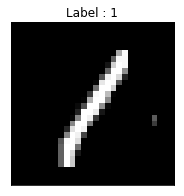

In [3]:
# Check data
train_x, train_y = mnist.train.next_batch(10)
img = train_x[9,:].reshape(28, 28)

plt.figure(figsize=(5, 3))
plt.imshow(img,'gray')
plt.title("Label : {}".format(np.argmax(train_y[9])))
plt.xticks([])
plt.yticks([])
plt.show()

# Build RNN

In [4]:
n_step = 14
n_input = 28

## LSTM shape
n_lstm1 = 128
n_lstm2 = 258

## Fully connected
n_hidden1 = 100
n_output = 28
n_labels = 10

# RNN Model(save,load)

In [12]:
class RNN:
    '''
    <Configuration example>
    config = {
        'ID' : 'test_NN',
        'n_iter' : 5000,
        'n_prt' : 100,
        'n_input' : 28,
        'n_step' : 14,
        'n_output' : 28,
        'n_batch' : 50,
        'n_save' : 1000,
        'n_history' : 50,
        'LR' : 0.0002
    }
    '''
    def __init__(self, config):
        self.ID = config['ID']
        self.n_iter = config['n_iter']
        self.n_prt = config['n_prt']
        self.n_input = config['n_input']
        self.n_step = config['n_step']
        self.n_output = config['n_output']
        self.n_batch = config['n_batch']
        self.n_save = config['n_save']
        self.n_history = config['n_history']
        self.LR = config['LR']
        self.history = {
            'train' : [],
        }
        
        self.checkpoint = 0
        self.path = './{}'.format(self.ID)
        try: 
            os.mkdir(self.path)
            os.mkdir('{0}/{1}'.format(self.path, 'checkpoint'))
        except FileExistsError:
            msg = input('[FileExistsError] Will you remove directory? [Y/N] ')
            if msg == 'Y': # or debug 
                shutil.rmtree(self.path)
                os.mkdir(self.path)
                os.mkdir('{0}/{1}'.format(self.path, 'checkpoint'))
            else: 
                print('Please choose another ID')
                assert 0
                  
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.x = tf.placeholder(tf.float32, [None, self.n_step, self.n_input], name='x')
            self.y = tf.placeholder(tf.float32, [None, self.n_output], name='y')
            
            self.feature = self.feature_map(self.x)
            self.pred = self.clf(self.feature['hidden1'])

            self.loss = self.compute_loss(self.pred, self.y)
            self.optm = tf.train.AdamOptimizer(learning_rate=self.LR).minimize(self.loss)
            self.init = tf.global_variables_initializer()
            self.saver = tf.train.Saver(max_to_keep=None)
        
        self.sess = tf.Session(graph=self.graph, config=tf.ConfigProto(allow_soft_placement=True))
        self.sess.run(self.init)
        
        print('Model ID : {}'.format(self.ID))
        print('Model saved at : {}'.format(self.path))

    ## Layers
    def fully_connected_layer(self, input_tensor, name, n_out, activation_fn=tf.nn.relu):
        n_in = input_tensor.get_shape()[-1].value
        with tf.variable_scope(name):
            weight = tf.get_variable('weight', [n_in, n_out], tf.float32)
            bias = tf.get_variable('bias', [n_out], tf.float32, tf.constant_initializer(0.0))
            logits = tf.add(tf.matmul(input_tensor, weight), bias, name='logits')
        if activation_fn is None : return logits
        else : return activation_fn(logits, name='activation')

    def lstm_layer(self, input_tensor, name, n_out):
        with tf.variable_scope('rnn'):
            with tf.variable_scope(name):
                lstm = tf.contrib.rnn.BasicLSTMCell(n_out, forget_bias=1.0)
                h, c = tf.nn.dynamic_rnn(lstm, input_tensor, dtype=tf.float32)
        return h
        
    ## Feature map
    def feature_map(self, x):
        with tf.variable_scope('feature_map'):
            lstm1_h = self.lstm_layer(x, 'lstm1_h', 128)
            lstm2_h = self.lstm_layer(lstm1_h, 'lstm2_h', 256)
            hidden1 = self.fully_connected_layer(lstm2_h[:,-1,:], 'hidden1', 100)
        return {
            'hidden1' : hidden1
        }
    
    ## Compute loss
    def compute_loss(self, pred, y):
        with tf.variable_scope('compute_loss'):
            loss = tf.square(tf.subtract(pred, y))
            loss = tf.reduce_mean(loss)
        return loss

    ## Classifier
    def clf(self, feature):
        with tf.variable_scope('clf'):
            pred = self.fully_connected_layer(feature, 'pred', self.n_output, None)
        return pred
    
    ## Train
    def fit(self, data):
        for epoch in range(1, self.n_iter+1):
            train_x, train_y = data.train.next_batch(self.n_batch)
            train_x = train_x.reshape(-1, 28, 28)
            
            for j in range(self.n_step):
                self.sess.run(self.optm, feed_dict={self.x: train_x[:,j:j+self.n_step,:],  self.y: train_x[:,j+self.n_step]})
            
            if epoch % self.n_prt == 0:
                train_loss = self.get_loss(train_x[:,13:13+n_step,:], train_x[:,13+n_step])
                print('Your loss ({0}/{1}) : {2}'.format(epoch, self.n_iter, train_loss))
                
            if epoch % self.n_save == 0:
                self.checkpoint += self.n_save
                self.save('{0}/{1}/{2}_{3}'.format(self.path, 'checkpoint', self.ID, self.checkpoint))
            
            if epoch % self.n_history == 0:
                test_x, test_y = data.test.next_batch(self.n_batch)
                train_loss = self.get_loss(train_x[:,13:13+n_step,:], train_x[:,13+n_step])
                self.history['train'].append(train_loss)
    
    ## Predict
    def predict(self, x):
        gen_img = []
        sample = x.copy()
        feeding_img = x.copy()
        
        for i in range(n_step):
            test_pred = self.sess.run(self.pred, feed_dict={self.x: feeding_img.reshape(1, 14, 28)})
            feeding_img = np.delete(feeding_img, 0, 0)
            feeding_img = np.vstack([feeding_img, test_pred])
            gen_img.append(test_pred)
        
        for i in range(n_step):
            sample = np.vstack([sample, gen_img[i]])
        
        return sample
    
    ## Analysis
    def get_feature(self, x):
        feature = self.sess.run(self.feature, feed_dict={self.x : x})
        return feature
    
    def get_loss(self, x, y):
        loss = self.sess.run(self.loss, feed_dict={self.x : x, self.y : y})
        return loss
    
    ## Save/Restore
    def save(self, path):
        self.saver.save(self.sess, path)
        
    def load(self, path):
        self.saver.restore(self.sess, path)
        checkpoint = path.split('_')[-1]
        self.checkpoint = int(checkpoint)
        print('Model loaded from file : {}'.format(path))
        

In [6]:
config = {
    'ID' : 'test_RNN',
    'n_iter' : 1000,
    'n_prt' : 100,
    'n_input' : 28,
    'n_step' : 14,
    'n_output' : 28,
    'n_batch' : 50,
    'n_save' : 1000,
    'n_history' : 50,
    'LR' : 0.0002
}

In [7]:
my_rnn = RNN(config=config)

[FileExistsError] Will you remove directory? [Y/N] Y
Model ID : test_RNN
Model saved at : ./test_RNN


In [8]:
my_rnn.fit(mnist)

Your loss (100/1000) : 0.0024459324777126312
Your loss (200/1000) : 0.0022213668562471867
Your loss (300/1000) : 0.0014402030501514673
Your loss (400/1000) : 0.002330318558961153
Your loss (500/1000) : 0.0037491172552108765
Your loss (600/1000) : 0.004020224791020155
Your loss (700/1000) : 0.0029807849787175655
Your loss (800/1000) : 0.001068581361323595
Your loss (900/1000) : 0.0005581997684203088
Your loss (1000/1000) : 0.0012429053895175457
INFO:tensorflow:./test_RNN/checkpoint/test_RNN_1000 is not in all_model_checkpoint_paths. Manually adding it.


In [9]:
test_x, test_y = mnist.test.next_batch(10)
test_x = test_x.reshape(-1, 28, 28)

sample = test_x[0, 0:14,:]

In [14]:
config2 = {
    'ID' : 'test_RNN2',
    'n_iter' : 1000,
    'n_prt' : 100,
    'n_input' : 28,
    'n_step' : 14,
    'n_output' : 28,
    'n_batch' : 50,
    'n_save' : 1000,
    'n_history' : 50,
    'LR' : 0.0002
}

In [15]:
test_rnn = RNN(config=config2)

Model ID : test_RNN2
Model saved at : ./test_RNN2


In [16]:
test_rnn.load('./test_RNN/checkpoint/test_RNN_1000')

INFO:tensorflow:Restoring parameters from ./test_RNN/checkpoint/test_RNN_1000
Model loaded from file : ./test_RNN/checkpoint/test_RNN_1000


In [19]:
gen_img = test_rnn.predict(sample)

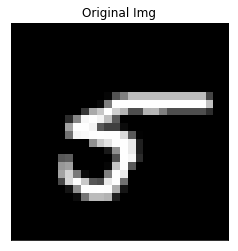

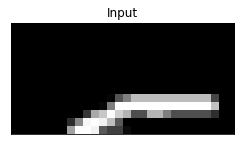

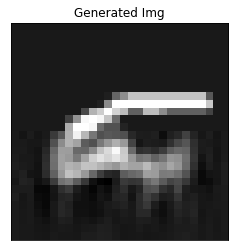

In [21]:
plt.imshow(test_x[0], 'gray')
plt.title('Original Img')
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(sample, 'gray')
plt.title('Input')
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(gen_img, 'gray')
plt.title('Generated Img')
plt.xticks([])
plt.yticks([])
plt.show()

In [22]:
config3 = {
    'ID' : 'Hanwha_RNN',
    'n_iter' : 5000,
    'n_prt' : 100,
    'n_input' : 28,
    'n_step' : 14,
    'n_output' : 28,
    'n_batch' : 50,
    'n_save' : 1000,
    'n_history' : 50,
    'LR' : 0.0002
}

In [23]:
hanwha_rnn = RNN(config=config3)

Model ID : Hanwha_RNN
Model saved at : ./Hanwha_RNN


In [24]:
hanwha_rnn.load('./test_RNN/checkpoint/test_RNN_1000')

INFO:tensorflow:Restoring parameters from ./test_RNN/checkpoint/test_RNN_1000
Model loaded from file : ./test_RNN/checkpoint/test_RNN_1000


In [25]:
hanwha_rnn.fit(mnist)

Your loss (100/5000) : 0.00036756834015250206
Your loss (200/5000) : 0.0011339897755533457
Your loss (300/5000) : 0.0031440616585314274
Your loss (400/5000) : 0.002004848560318351
Your loss (500/5000) : 9.84356738626957e-05
Your loss (600/5000) : 0.00048287506797350943
Your loss (700/5000) : 0.00141067651566118
Your loss (800/5000) : 0.001673096208833158
Your loss (900/5000) : 0.00010844600183190778
Your loss (1000/5000) : 0.0021798936650156975
INFO:tensorflow:./Hanwha_RNN/checkpoint/Hanwha_RNN_2000 is not in all_model_checkpoint_paths. Manually adding it.
Your loss (1100/5000) : 0.00038319596205838025
Your loss (1200/5000) : 0.002291044918820262
Your loss (1300/5000) : 0.0023889155127108097
Your loss (1400/5000) : 0.00195339135825634
Your loss (1500/5000) : 0.002840400207787752
Your loss (1600/5000) : 0.002319819526746869
Your loss (1700/5000) : 0.0006462199380621314
Your loss (1800/5000) : 4.039785562781617e-05
Your loss (1900/5000) : 0.000664272578433156
Your loss (2000/5000) : 0.00

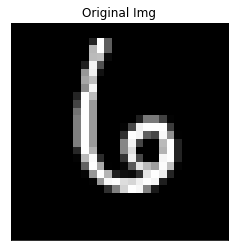

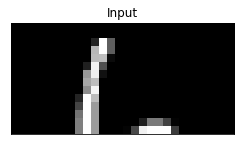

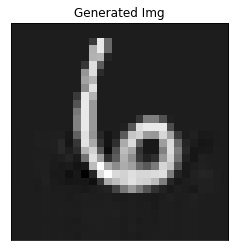

In [191]:
test_x, test_y = mnist.test.next_batch(10)
test_x = test_x.reshape(-1, 28, 28)

sample = test_x[0, 0:14,:]

gen_img = hanwha_rnn.predict(sample)

plt.imshow(test_x[0], 'gray')
plt.title('Original Img')
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(sample, 'gray')
plt.title('Input')
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(gen_img, 'gray')
plt.title('Generated Img')
plt.xticks([])
plt.yticks([])
plt.show()

In [114]:
config3 = {
    'ID' : 'Hanwha_RNN2',
    'n_iter' : 5000,
    'n_prt' : 100,
    'n_input' : 28,
    'n_step' : 14,
    'n_output' : 28,
    'n_batch' : 50,
    'n_save' : 1000,
    'n_history' : 50,
    'LR' : 0.0002
}

In [115]:
mm = RNN(config=config3)

Model ID : Hanwha_RNN2
Model saved at : ./Hanwha_RNN2


In [116]:
mm.load('./Hanwha_RNN/checkpoint/Hanwha_RNN_2000')

INFO:tensorflow:Restoring parameters from ./Hanwha_RNN/checkpoint/Hanwha_RNN_2000
Model loaded from file : ./Hanwha_RNN/checkpoint/Hanwha_RNN_2000


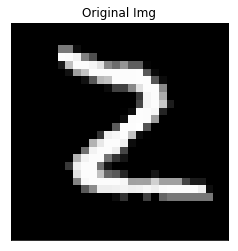

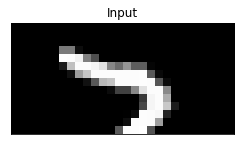

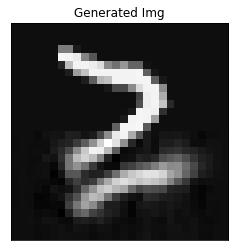

In [180]:
test_x, test_y = mnist.test.next_batch(10)
test_x = test_x.reshape(-1, 28, 28)

sample = test_x[0, 0:14,:]

gen_img = mm.predict(sample)

plt.imshow(test_x[0], 'gray')
plt.title('Original Img')
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(sample, 'gray')
plt.title('Input')
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(gen_img, 'gray')
plt.title('Generated Img')
plt.xticks([])
plt.yticks([])
plt.show()